**Để chạy file này tất các file mà nhóm để trong folder `Dữ liệu chạy cảnh báo` tuy nhiên khi chạy sẽ `không log tín hiệu lên ggsheet được` vì khi share log ggsheet lên github thì keys đã bị tự động disabled

**Trước tiên để chạy ta cần lọc universe để chọn top 200 mã thỏa điều kiện**

**Tuy nhiên không cần chạy lại vì nhóm đã lưu dữ liệu vào folder `universe` trên repo git chỉ cần giải nén và để vào cùng thư mục với file notebook này**

In [ ]:
# Block 1 — Config & Login
# =======================================
import os, json
from datetime import datetime
from FiinQuantX import FiinSession
# -------------------
# Step 2: Load config
# -------------------
with open("config.json","r") as f:
    config = json.load(f)

username = config.get("username")
password = config.get("password")

# -------------------
# Step 3: Login FiinQuant
# -------------------
try:
    client = FiinSession(username, password).login()
    print("✅ Login FiinQuant thành công")
except Exception as e:
    raise RuntimeError(f"❌ Login FiinQuant thất bại: {e}")

# -------------------
# Step 4: Init Telegram (nếu có)
# -------------------
bot, CHAT_ID = None, None
if config.get("telegram_token") and config.get("telegram_cha
    import telegram
    try:
        bot = telegram.Bot(token=config["telegram_token"])
        CHAT_ID = config["telegram_chat_id"]
        print("✅ Telegram Bot ready")
    except Exception as e:
        print(f"⚠️ Telegram init lỗi: {e}")

# -------------------
# Step 5: Init Google Sheets (nếu có)
# -------------------
gs_client, sheet_id = None, None
if config.get("google_sheet_id") and os.path.exists(config.g
    import gspread
    from oauth2client.service_account import ServiceAccountC
    try:
        scope = ["https://spreadsheets.google.com/feeds","ht
        creds = ServiceAccountCredentials.from_json_keyfile_
        gs_client = gspread.authorize(creds)
        sheet_id = config["google_sheet_id"]
        print("✅ Google Sheets client ready")
    except Exception as e:
        print(f"⚠️ Google Sheets init lỗi: {e}")

# -------------------
# Step 6: Init runtime_state.json
# -------------------
runtime_file = "runtime_state.json"
if not os.path.exists(runtime_file):
    runtime_state = {
        "api_used": 0,
        "month": datetime.now().strftime("%Y-%m"),
        "last_universe": None,
        "last_run_time": None,
        "last_alerts": {}
    }
    with open(runtime_file, "w") as f:
        json.dump(runtime_state, f, indent=2)
    print("✅ runtime_state.json created")
else:
    with open(runtime_file, "r") as f:
        runtime_state = json.load(f)
    print("ℹ️ Loaded existing runtime_state.json")

# -------------------
# Done
# -------------------
print("🎯 Block 1 hoàn tất: Config & Login")

In [ ]:
# Block 2 — Universe Selection (Monthly job)
# ================================================

import pandas as pd
import numpy as np
import os, json
from datetime import datetime

# ---- Step 1: Lấy danh sách tickers toàn thị trường ----
tickers_hose  = list(client.TickerList(ticker="VNINDEX"))
tickers_all = list(set(tickers_hose))
print(f"Tổng số tickers toàn thị trường: {len(tickers_all)}")

# ---- Step 2: Lấy dữ liệu OHLCV 6 tháng gần nhất ----
ohlcv = client.Fetch_Trading_Data(
    realtime=False,
    tickers=tickers_all,
    fields=["close","volume"],
    adjusted=True,
    by="1d",
    from_date="2025-03-01"   # ~6 tháng gần đây
).get_data()

ohlcv["timestamp"] = pd.to_datetime(ohlcv["timestamp"])

# ---- Step 3: Tính liquidity (20d avg value traded) ----
ohlcv["value"] = ohlcv["close"] * ohlcv["volume"]
liquidity_20d = ohlcv.groupby("ticker")["value"].rolling(20).mean().reset_index(level=0, drop=True)
latest_liquidity = liquidity_20d.groupby(ohlcv["ticker"]).last()

# ---- Step 4: Tính momentum (90d, 252d) ----
def calc_momentum(series, window):
    if len(series) < window: 
        return np.nan
    return series.iloc[-1] / series.iloc[-window] - 1

momentum_90d = ohlcv.groupby("ticker")["close"].apply(lambda x: calc_momentum(x, 90))
momentum_252d = ohlcv.groupby("ticker")["close"].apply(lambda x: calc_momentum(x, 252))

# ---- Step 5: Lấy dữ liệu FA (check FA flag) ----
fa_flags = {}
for t in tickers_all:
    try:
        fi_list = client.FundamentalAnalysis().get_ratios(
            tickers=[t],
            TimeFilter="Quarterly",
            LatestYear=2025,
            NumberOfPeriod=8,
            Consolidated=True
        )
        fa_flags[t] = 1 if fi_list else 0
    except Exception as e:
        print(f"⚠️ Lỗi khi lấy FA {t}: {e}")
        fa_flags[t] = 0

fa_flag_series = pd.Series(fa_flags, name="FA_flag")

# ---- Step 6: Gộp dữ liệu ----
df_universe = pd.DataFrame({
    "ticker": list(latest_liquidity.index),
    "liquidity_20d": latest_liquidity.values,
    "momentum_90d": momentum_90d.values,
    "momentum_252d": momentum_252d.values
}).set_index("ticker")

df_universe = df_universe.join(fa_flag_series, how="left").fillna(0)
df_universe = df_universe.reset_index()

# ---- Step 7: Ranking & chọn Universe ----
df_universe["liquidity_rank"] = df_universe["liquidity_20d"].rank(pct=True)
df_universe["momentum_rank"]  = df_universe["momentum_90d"].rank(pct=True)

# Composite score (simple average)
df_universe["score"] = (df_universe["liquidity_rank"] + df_universe["momentum_rank"]) / 2

# Chọn top 200
univ_final = df_universe.sort_values("score", ascending=False).head(200)

# ---- Step 8: Save results ----
os.makedirs("universe", exist_ok=True)

csv_file = "universe/universe_list.csv"
meta_file = "universe/universe_metadata.json"

univ_final.to_csv(csv_file, index=False)
print(f"💾 Saved {csv_file} with {len(univ_final)} tickers")

meta = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "universe_size": len(univ_final),
    "selection_method": "liquidity + momentum + FA_flag",
}
with open(meta_file, "w") as f:
    json.dump(meta, f, indent=4)

print(f"📘 Metadata saved: {meta_file}")
print("✅ Universe sample:")
print(univ_final.head())

**Tiếp theo ta cần chạy cell ngay bên dưới để định nghĩa các hàm đồng thời tải lên các file cần thiết cho việc chạy hệ thống cảnh báo realtime và stress test**

**Ta cần chuẩn bị các file cần thiết ở phần `readme trên repo git` để chạy ra kết quả chính xác nhất**

**Lưu ý**: ngay cả khi thiếu 1 số file trong folder như trong folder model, tensor,... thì vẫn chạy được tuy nhiên kết quả sẽ `không chính xác` vì lúc đó rơi vào trường hợp fallback nhóm sẽ để các tham số 1 cách ngẫu nhiên để lúc chạy cell không bị lỗi 

In [9]:
# ====================================================================================
# Unified pipeline cell (Realtime + Stress + A3C train/infer + DDPG train/backtest +
# Alerts (Telegram + Google Sheets) + Position management)
# Paste whole cell into a single notebook cell and run.
# Edit config.json if needed. Requires: pandas, numpy, torch, requests, gspread (optional)
# ====================================================================================

import os, sys, time, json, math, glob, traceback, random, re, gc
from datetime import datetime, timedelta
from typing import Optional, Tuple, List, Dict
import numpy as np
import pandas as pd

# --------------------------
# Load config.json if present
# --------------------------
BASE_DIR = os.getcwd()
CFG_PATH = os.path.join(BASE_DIR, "config.json")
cfg = {}
if os.path.exists(CFG_PATH):
    try:
        with open(CFG_PATH, "r", encoding="utf-8") as fh:
            cfg = json.load(fh)
        print(f"[config] loaded {CFG_PATH}")
    except Exception as e:
        print("[config] load error:", e)
else:
    print("[config] config.json not found, using defaults")

# --------------------------
# Paths & params
# --------------------------
DATA_DIR    = cfg.get("paths", {}).get("data_dir", "./data")
TENSOR_DIR  = cfg.get("paths", {}).get("tensor_dir", "./tensors")
MODEL_DIR   = cfg.get("paths", {}).get("model_dir", "./models")
FEATURE_DIR = cfg.get("paths", {}).get("features_dir", "./features")
SIGNAL_DIR  = cfg.get("paths", {}).get("signals_dir", "./signals")
MONITOR_DIR = cfg.get("paths", {}).get("monitor_dir", "./monitor")
ALERT_DIR   = cfg.get("paths", {}).get("alert_dir", "./alerts")
UNIVERSE_CSV= cfg.get("paths", {}).get("universe_dir", "./universe/universe_list.csv")
OUTPUT_DIR  = cfg.get("paths", {}).get("backtest_dir", "./backtest_ddpg")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(TENSOR_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(FEATURE_DIR, exist_ok=True)
os.makedirs(SIGNAL_DIR, exist_ok=True)
os.makedirs(MONITOR_DIR, exist_ok=True)
os.makedirs(ALERT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Telegram & Google credentials from config (flexible keys)
TG_TOKEN = cfg.get("telegram", {}).get("bot_token") or cfg.get("telegram", {}).get("bot_token", "") or cfg.get("telegram", {}).get("token", "")
TG_CHAT_ID = cfg.get("telegram", {}).get("chat_id") or cfg.get("telegram", {}).get("chat_id", "")
TG_THREAD_ID = cfg.get("telegram", {}).get("message_thread_id") or cfg.get("telegram", {}).get("message_thread_id", None)

GS_SERVICE_JSON = cfg.get("google", {}).get("service_account_json") or cfg.get("google", {}).get("service_json", "")
GS_SHEET_KEY = cfg.get("google", {}).get("sheet_id") or cfg.get("google", {}).get("sheet_key", "")
GS_SHEET_NAME = cfg.get("google", {}).get("sheet_name", "DSTRound3")

# pipeline params
UNIVERSE_SIZE = cfg.get("pipeline", {}).get("universe_size", 200)
TOPK = cfg.get("pipeline", {}).get("topk", 10)
RSI_TH = cfg.get("pipeline", {}).get("rsi_buy_threshold", 35)
VOL_SPIKE_MULT = cfg.get("pipeline", {}).get("vol_spike_mult", 1.5)
RULE_MIN_SCORE = cfg.get("pipeline", {}).get("rule_min_score", 3)
MIN_ALLOC = cfg.get("pipeline", {}).get("min_alloc", 0.005)
EXEC_LAG = cfg.get("pipeline", {}).get("execution_lag", 2)
STATE_LKBK = cfg.get("pipeline", {}).get("state_lookback", 10)
DEFAULT_START_DATE = "2025-03-25"
DEFAULT_END_DATE = "2025-04-16"

print("Paths set:")
print("  DATA_DIR:", DATA_DIR)
print("  TENSOR_DIR:", TENSOR_DIR)
print("  MODEL_DIR:", MODEL_DIR)
print("  FEATURE_DIR:", FEATURE_DIR)
print("  SIGNAL_DIR:", SIGNAL_DIR)
print("  MONITOR_DIR:", MONITOR_DIR)
print("  ALERT_DIR:", ALERT_DIR)

# --------------------------
# Utilities: Telegram (retry-aware), Google Sheets (optional)
# --------------------------
import requests

def escape_markdown_v2(text: str) -> str:
    if text is None:
        return ""
    # escape for MarkdownV2
    return re.sub(r'([_*[\]()~`>#+\-=|{}.!])', r'\\\1', str(text))

def send_telegram_text(msg: str, thread_id: Optional[int]=None, parse_mode: Optional[str]="Markdown", max_retries: int = 3) -> bool:
    """
    Send text message to Telegram. Handles HTTP 429 with retry-after.
    parse_mode: "Markdown" or "MarkdownV2" or None
    """
    if not TG_TOKEN or not TG_CHAT_ID:
        print("[tg] token/chat not configured")
        return False
    url = f"https://api.telegram.org/bot{TG_TOKEN}/sendMessage"
    payload = {"chat_id": TG_CHAT_ID, "text": msg}
    if parse_mode == "MarkdownV2":
        payload["text"] = escape_markdown_v2(msg)
        payload["parse_mode"] = "MarkdownV2"
    elif parse_mode == "Markdown":
        payload["parse_mode"] = "Markdown"
    if thread_id is not None:
        try:
            payload["message_thread_id"] = int(thread_id)
        except Exception:
            pass
    for attempt in range(max_retries):
        try:
            r = requests.post(url, json=payload, timeout=20)
            if r.status_code == 200:
                return True
            elif r.status_code == 429:
                # rate limited
                try:
                    j = r.json()
                    ra = int(j.get("parameters", {}).get("retry_after", 5))
                except Exception:
                    ra = 5
                print(f"[tg] send failed: 429, retry after {ra}s")
                time.sleep(ra + 1)
                continue
            else:
                print(f"[tg] send failed: {r.status_code} {r.text}")
                return False
        except Exception as e:
            print("[tg] exception:", e)
            time.sleep(1)
    return False

def send_telegram_file(path: str, caption: str = "", thread_id: Optional[int]=None) -> bool:
    if not TG_TOKEN or not TG_CHAT_ID:
        print("[tg] token/chat not configured")
        return False
    url = f"https://api.telegram.org/bot{TG_TOKEN}/sendDocument"
    data = {"chat_id": TG_CHAT_ID, "caption": caption}
    if thread_id is not None:
        try:
            data["message_thread_id"] = int(thread_id)
        except Exception:
            pass
    try:
        with open(path, "rb") as fh:
            files = {"document": fh}
            r = requests.post(url, data=data, files=files, timeout=60)
        if r.status_code != 200:
            print("[tg] sendDocument failed:", r.status_code, r.text)
            return False
        return True
    except Exception as e:
        print("[tg] sendDocument exception:", e)
        return False

# Google Sheets optional
PUSH_GSHEET = bool(GS_SHEET_KEY and os.path.exists(GS_SERVICE_JSON))
GS_CLIENT = None
GS_SHEET = None
if PUSH_GSHEET:
    try:
        import gspread
        from gspread_dataframe import set_with_dataframe
        from google.oauth2.service_account import Credentials
        GS_CREDS = Credentials.from_service_account_file(GS_SERVICE_JSON, scopes=[
            "https://www.googleapis.com/auth/spreadsheets",
            "https://www.googleapis.com/auth/drive"
        ])
        GS_CLIENT = gspread.authorize(GS_CREDS)
        GS_SHEET = GS_CLIENT.open_by_key(GS_SHEET_KEY)
        print("[gs] Google Sheets ready")
    except Exception as e:
        print("[gs] init failed, disabling PUSH_GSHEET. Error:", e)
        PUSH_GSHEET = False

def append_to_gsheet(df: pd.DataFrame, worksheet_name: str = "Alerts"):
    if not PUSH_GSHEET or GS_CLIENT is None:
        return False
    try:
        try:
            ws = GS_SHEET.worksheet(worksheet_name)
        except Exception:
            ws = GS_SHEET.add_worksheet(title=worksheet_name, rows="1000", cols="20")
        append_df_to_gsheet(df, ws)
        return True
    except Exception as e:
        print("[gs] append to gsheet error:", e)
        return False

def append_df_to_gsheet(df: pd.DataFrame, worksheet, batch_size: int = 500) -> bool:
    df2 = df.copy().replace([np.inf, -np.inf], np.nan).fillna("")
    rows = df2.values.tolist()
    try:
        for i in range(0, len(rows), batch_size):
            chunk = rows[i:i+batch_size]
            worksheet.append_rows(chunk, value_input_option="RAW")
        return True
    except Exception as e:
        print("[gs] append error:", e)
        return False

# --------------------------
# runtime state save/load
# --------------------------
RUNTIME_STATE_PATH = os.path.join(MONITOR_DIR, "runtime_state.json")
def load_runtime_state():
    if os.path.exists(RUNTIME_STATE_PATH):
        try:
            with open(RUNTIME_STATE_PATH, "r", encoding="utf-8") as fh:
                return json.load(fh)
        except Exception:
            return {}
    return {}

def save_runtime_state(state: Optional[dict] = None):
    s = state if state is not None else runtime_state
    try:
        with open(RUNTIME_STATE_PATH, "w", encoding="utf-8") as fh:
            json.dump(s, fh, ensure_ascii=False, indent=2)
        print("[runtime] state saved")
    except Exception as e:
        print("[runtime] save error:", e)

runtime_state = load_runtime_state()
if "last_alerts" not in runtime_state:
    runtime_state["last_alerts"] = {}
if "positions" not in runtime_state:
    runtime_state["positions"] = []

# --------------------------
# FiinQuantX client helper (optional)
# --------------------------
FQ_AVAILABLE = False
try:
    from FiinQuantX import FiinSession
    FQ_AVAILABLE = True
except Exception:
    FQ_AVAILABLE = False

def init_fiin_client(username=None, password=None):
    username = username or cfg.get("fiinquant", {}).get("username") or cfg.get("fiin", {}).get("username")
    password = password or cfg.get("fiinquant", {}).get("password") or cfg.get("fiin", {}).get("password")
    if not FQ_AVAILABLE:
        print("[init] FiinQuantX not available")
        return None
    try:
        client = FiinSession(username=username, password=password).login()
        print("[init] Fiin client logged in")
        return client
    except Exception as e:
        print("[init] Fiin login failed:", e)
        return None

# --------------------------
# TA/indicators builder (FiinIndicator fallback to pandas)
# --------------------------
def add_ta_indicators_for_df(df: pd.DataFrame, fi=None) -> pd.DataFrame:
    df = df.sort_values("timestamp").copy().reset_index(drop=True)
    try:
        if fi is not None:
            # use fi functions where available
            df['ema_5'] = fi.ema(df['close'], window=5)
            df['ema_20'] = fi.ema(df['close'], window=20)
            df['ema_50'] = fi.ema(df['close'], window=50)
            try:
                df['macd'] = fi.macd(df['close'], window_fast=12, window_slow=26)
                df['macd_signal'] = fi.macd_signal(df['close'], window_fast=12, window_slow=26, window_sign=9)
                df['macd_diff'] = df['macd'] - df['macd_signal']
            except Exception:
                df['macd'] = np.nan; df['macd_signal'] = np.nan; df['macd_diff'] = np.nan
            df['rsi_14'] = fi.rsi(df['close'], window=14)
            try:
                df['boll_up'] = fi.bollinger_hband(df['close'], window=20, window_dev=2)
                df['boll_dn'] = fi.bollinger_lband(df['close'], window=20, window_dev=2)
            except Exception:
                df['boll_up'] = np.nan; df['boll_dn'] = np.nan
            df['atr_14'] = fi.atr(df['high'], df['low'], df['close'], window=14)
            df['obv'] = fi.obv(df['close'], df['volume'])
            try:
                df['vwap_20'] = fi.vwap(df['high'], df['low'], df['close'], df['volume'], window=20)
            except Exception:
                df['vwap_20'] = np.nan
            df['vol_z'] = (df['volume'] - df['volume'].rolling(20).mean()) / (df['volume'].rolling(20).std().replace(0, np.nan))
        else:
            # pandas fallback
            df['ema_5'] = df['close'].ewm(span=5, adjust=False).mean()
            df['ema_20'] = df['close'].ewm(span=20, adjust=False).mean()
            df['ema_50'] = df['close'].ewm(span=50, adjust=False).mean()
            macd = df['close'].ewm(span=12, adjust=False).mean() - df['close'].ewm(span=26, adjust=False).mean()
            macd_sig = macd.ewm(span=9, adjust=False).mean()
            df['macd'] = macd; df['macd_signal'] = macd_sig; df['macd_diff'] = macd - macd_sig
            delta = df['close'].diff()
            up = delta.clip(lower=0).rolling(14).mean()
            down = -delta.clip(upper=0).rolling(14).mean()
            rs = up / (down.replace(0, np.nan))
            df['rsi_14'] = 100 - (100 / (1 + rs))
            df['boll_up'] = df['close'].rolling(20).mean() + 2 * df['close'].rolling(20).std()
            df['boll_dn'] = df['close'].rolling(20).mean() - 2 * df['close'].rolling(20).std()
            df['atr_14'] = (df['high'] - df['low']).rolling(14).mean()
            df['obv'] = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()
            df['vwap_20'] = (df['close'] * df['volume']).rolling(20).sum() / (df['volume'].rolling(20).sum().replace(0, np.nan))
            df['vol_z'] = (df['volume'] - df['volume'].rolling(20).mean()) / (df['volume'].rolling(20).std().replace(0, np.nan))
    except Exception as e:
        print("[TA] indicator compute error:", e)
    return df

# --------------------------
# Backfill master if needed
# --------------------------
def backfill_master(client, universe: List[str], months=6):
    master_path = os.path.join(DATA_DIR, "ohlcv_master.parquet")
    if os.path.exists(master_path):
        return master_path
    if client is None:
        print("[backfill] no client -> cannot backfill")
        return None
    to_date = datetime.now().date()
    from_date = (datetime.now() - pd.DateOffset(months=months)).date()
    print(f"[backfill] requesting historical OHLCV for {len(universe)} tickers from {from_date} to {to_date}")
    all_rows=[]
    batch_size = 50
    for i in range(0, len(universe), batch_size):
        batch = universe[i:i+batch_size]
        try:
            data = client.Fetch_Trading_Data(
                realtime=False,
                tickers=batch,
                fields=['open','high','low','close','volume','bu','sd','fb','fs','fn'],
                adjusted=True,
                by='1d',
                from_date=str(from_date),
                to_date=str(to_date)
            ).get_data()
            if data is not None and not data.empty:
                all_rows.append(data)
            time.sleep(0.2)
        except Exception as e:
            print("[backfill] batch fetch error:", e)
    if all_rows:
        df_master = pd.concat(all_rows, ignore_index=True)
        df_master.to_parquet(master_path, index=False)
        print(f"[backfill] saved master parquet {master_path} rows={len(df_master)}")
        return master_path
    else:
        print("[backfill] no data fetched")
        return None

# --------------------------
# A3C model wrapper / loader (robust)
# --------------------------
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[torch] device:", device)

class A3CNet(nn.Module):
    def __init__(self, n_features, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden, batch_first=True)
        self.actor = nn.Linear(hidden, 3)
        self.critic = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        h = out[:, -1, :]
        return self.actor(h), self.critic(h)

class DummyActorLinear(nn.Module):
    def __init__(self, n_in, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 3)
        )
    def forward(self, x):
        B,T,F = x.shape
        z = x.reshape(B, -1)
        logits = self.net(z)
        return logits, torch.zeros((B,1), device=logits.device, dtype=logits.dtype)

class A3CWrapper:
    def __init__(self, model, model_type="a3c"):
        self.model = model
        self.model_type = model_type
    def to(self, device):
        self.model.to(device)
        return self
    def eval(self):
        self.model.eval()
    def __call__(self, x):
        return self.model(x)

def load_cluster_a3c_model(path: str, input_shape_hint: Tuple[int,int]=None):
    """
    Load checkpoint robustly - supports state_dict of full A3CNet, or actor-only.
    If mismatch shapes, fallback to dummy actor.
    """
    if not os.path.exists(path):
        return None
    try:
        sd = torch.load(path, map_location="cpu")
        if isinstance(sd, dict):
            keys = list(sd.keys())
            # detect full A3C keys
            if any("lstm.weight_ih_l0" in k for k in keys) or any("actor.weight" in k for k in keys):
                # need input feature count
                input_size = None
                for k in keys:
                    if "lstm.weight_ih_l0" in k:
                        w = sd[k]
                        input_size = max(1, w.shape[1] // 4)
                        break
                if input_size is None and input_shape_hint is not None:
                    _, F = input_shape_hint
                    input_size = F
                if input_size is None:
                    input_size = 8
                try:
                    model = A3CNet(n_features=input_size)
                    model.load_state_dict(sd, strict=False)
                    model.to(device)
                    return A3CWrapper(model, model_type="a3c")
                except Exception as e:
                    print("[a3c] partial load into A3CNet failed:", e)
            # try actor-only
            # actor-only usually has keys like '0.weight' or 'weight' and 'bias'
            if any(k.endswith("weight") or k.endswith("bias") or k.startswith("0.") for k in keys):
                if input_shape_hint:
                    T,F = input_shape_hint
                    in_dim = T * F
                else:
                    in_dim = 64
                try:
                    model = DummyActorLinear(in_dim)
                    # try to load into first linear layer if compatible
                    try:
                        # map keys heuristically
                        # if state dict is of nn.Sequential([...]) it might be '0.weight','0.bias'
                        model_sd = {}
                        for k,v in sd.items():
                            # only copy first linear if shapes match
                            if "0.weight" in k or "weight" == k:
                                if list(v.shape) == list(model.net[0].weight.data.shape):
                                    model.net[0].weight.data.copy_(torch.tensor(v))
                                # else skip
                            if "0.bias" in k or "bias" == k:
                                if list(v.shape) == list(model.net[0].bias.data.shape):
                                    model.net[0].bias.data.copy_(torch.tensor(v))
                    except Exception:
                        pass
                    model.to(device)
                    return A3CWrapper(model, model_type="dummy")
                except Exception as e:
                    print("[a3c] actor-only load error:", e)
        else:
            # maybe saved full model object
            try:
                model = sd
                model.to(device)
                return A3CWrapper(model, model_type="a3c_object")
            except Exception:
                pass
    except Exception as e:
        print("[a3c] load model error:", e)
    # fallback dummy
    if input_shape_hint:
        T,F = input_shape_hint
        model = DummyActorLinear(T*F)
    else:
        model = DummyActorLinear(64)
    return A3CWrapper(model, model_type="dummy")

# --------------------------
# Run A3C inference from tensors using tensor_index.json
# --------------------------
def run_a3c_inference_from_tensors(tensor_index_json: str, data_dir: str = TENSOR_DIR, signals_out: str = None):
    if signals_out is None:
        signals_out = os.path.join(SIGNAL_DIR, f"a3c_signals_infer_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
    if not os.path.exists(tensor_index_json):
        print("[a3c] tensor_index.json not found:", tensor_index_json)
        return None
    with open(tensor_index_json, "r", encoding="utf-8") as fh:
        tensor_index = json.load(fh)
    rows = []
    for meta in tensor_index:
        c_id = meta.get("cluster")
        t_file = os.path.join(data_dir, meta.get("tensor_file"))
        m_file = os.path.join(data_dir, meta.get("mask_file"))
        tickers = meta.get("tickers", []) or []
        dates = meta.get("dates", []) or []
        if not os.path.exists(t_file) or not os.path.exists(m_file):
            # skip cluster if missing
            continue
        X = np.load(t_file, mmap_mode="r")
        M = np.load(m_file, mmap_mode="r")
        if X.size == 0:
            continue
        B,T,N,F = X.shape
        # prefer a3c_cluster_{c_id}.pt
        model_path_pt = os.path.join(MODEL_DIR, f"a3c_cluster_{c_id}.pt")
        model_path_pth = os.path.join(MODEL_DIR, f"a3c_actor_cluster_{c_id}.pth")
        wrapper = None
        if os.path.exists(model_path_pt):
            try:
                wrapper = load_cluster_a3c_model(model_path_pt, input_shape_hint=(T,F))
                wrapper.to(device); wrapper.eval()
            except Exception as e:
                print("[a3c] load full model fail:", model_path_pt, e)
        if wrapper is None and os.path.exists(model_path_pth):
            try:
                wrapper = load_cluster_a3c_model(model_path_pth, input_shape_hint=(T,F))
                wrapper.to(device); wrapper.eval()
            except Exception as e:
                print("[a3c] load actor-only fail:", model_path_pth, e)
        if wrapper is None:
            wrapper = load_cluster_a3c_model(model_path_pth, input_shape_hint=(T,F))
            wrapper.to(device); wrapper.eval()

        total = B * N
        for s in range(total):
            b, n = divmod(s, N)
            xb = X[b, :, n, :]
            mb = M[b, :, n, :]
            xb = np.nan_to_num(xb, nan=0.0)
            xb_t = torch.tensor(xb[None, :, :], dtype=torch.float32, device=device)
            with torch.no_grad():
                logits, _ = wrapper(xb_t)
                probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
                act_idx = int(np.argmax(probs))  # 0,1,2
                action_mapped = act_idx - 1  # -> -1,0,1
            date_str = dates[b] if dates and b < len(dates) else datetime.now().strftime("%Y-%m-%d")
            ticker = tickers[n] if n < len(tickers) else None
            rows.append([date_str, ticker, int(action_mapped), float(probs[2]), float(probs[1]), float(probs[0])])
    if rows:
        df = pd.DataFrame(rows, columns=["date","ticker","action","prob_buy","prob_hold","prob_sell"])
        df.to_csv(signals_out, index=False)
        print("[a3c] produced signals ->", signals_out)
        return signals_out
    else:
        print("[a3c] no signals created")
        return None

# --------------------------
# A3C fallback (rule-based fallback when model absent)
# --------------------------
def a3c_fallback_signals_from_snapshot(snapshot_df: pd.DataFrame):
    rows=[]
    for _, r in snapshot_df.iterrows():
        ema5 = r.get('ema_5', np.nan); ema20 = r.get('ema_20', np.nan); rsi = r.get('rsi_14', np.nan)
        buy = False
        try:
            if (not pd.isna(ema5) and not pd.isna(ema20) and ema5 > ema20) and (not pd.isna(rsi) and rsi < RSI_TH):
                buy = True
        except Exception:
            buy = False
        action = 1 if buy else 0
        pb, ph, ps = (0.75, 0.2, 0.05) if buy else (0.1, 0.85, 0.05)
        rows.append([datetime.now().strftime("%Y-%m-%d"), r['ticker'], int(action), float(pb), float(ph), float(ps), float(r.get("close", np.nan))])
    df = pd.DataFrame(rows, columns=["date","ticker","action","prob_buy","prob_hold","prob_sell","close"])
    return df

# --------------------------
# Rule scoring (5 checks) - returns DataFrame (date,ticker,rule_score,pass_list,fail_list,detail_values)
# --------------------------
def rule_scoring_from_snapshot(snapshot_df: pd.DataFrame, date_label: Optional[str]=None):
    rows=[]
    date_str = date_label or datetime.now().strftime("%Y-%m-%d")
    for _, r in snapshot_df.iterrows():
        ticker = r.get('ticker')
        ema5 = float(r.get('ema_5', np.nan)) if not pd.isna(r.get('ema_5', np.nan)) else np.nan
        ema20 = float(r.get('ema_20', np.nan)) if not pd.isna(r.get('ema_20', np.nan)) else np.nan
        rsi = float(r.get('rsi_14', np.nan)) if not pd.isna(r.get('rsi_14', np.nan)) else np.nan
        macd_diff = float(r.get('macd_diff', np.nan)) if not pd.isna(r.get('macd_diff', np.nan)) else np.nan
        close = float(r.get('close', np.nan)) if not pd.isna(r.get('close', np.nan)) else np.nan
        boll_up = float(r.get('boll_up', np.nan)) if not pd.isna(r.get('boll_up', np.nan)) else np.nan
        vol_z = float(r.get('vol_z', np.nan)) if not pd.isna(r.get('vol_z', np.nan)) else np.nan

        score=0; pass_list=[]; fail_list=[]
        if not math.isnan(ema5) and not math.isnan(ema20) and ema5 > ema20:
            score += 1; pass_list.append("EMA5>EMA20")
        else:
            fail_list.append("EMA<=20")
        if not math.isnan(rsi) and rsi < RSI_TH:
            score += 1; pass_list.append("RSI<TH")
        else:
            fail_list.append("RSI>=")
        if not math.isnan(macd_diff) and macd_diff > 0:
            score += 1; pass_list.append("MACD>0")
        else:
            fail_list.append("MACD<=0")
        if not math.isnan(close) and not math.isnan(boll_up) and close > boll_up:
            score += 1; pass_list.append("BollBreak")
        else:
            fail_list.append("BollNo")
        if not math.isnan(vol_z) and vol_z > VOL_SPIKE_MULT:
            score += 1; pass_list.append("VolSpike")
        else:
            fail_list.append("VolNormal")

        details = {"ema5":ema5,"ema20":ema20,"rsi":rsi,"macd_diff":macd_diff,"close":close,"boll_up":boll_up,"vol_z":vol_z}
        rows.append([date_str, ticker, int(score), ";".join(pass_list), ";".join(fail_list), json.dumps(details)])
    df = pd.DataFrame(rows, columns=["date","ticker","rule_score","pass_list","fail_list","detail_values"])
    return df

# --------------------------
# DDPG actor loader (for cluster allocations)
# --------------------------
class DummyDDPGActor(nn.Module):
    def __init__(self, n_clusters):
        super().__init__()
        self.lin = nn.Linear(n_clusters, n_clusters)
    def forward(self, s):
        raw = self.lin(s)
        p = torch.softmax(raw, dim=-1)
        return p

def load_ddpg_actor(path: str, n_clusters:int):
    if not os.path.exists(path):
        return None
    try:
        sd = torch.load(path, map_location="cpu")
        model = DummyDDPGActor(n_clusters)
        try:
            model.load_state_dict(sd, strict=False)
        except Exception:
            pass
        model.to(device); model.eval()
        return model
    except Exception as e:
        print("[ddpg] load actor error:", e)
        return None

# --------------------------
# Core: process_one_replay_day
# --------------------------
def process_one_replay_day(client, day_date, universe, master_df=None, use_precomputed_a3c=True, tensor_index_json=os.path.join(TENSOR_DIR,"tensor_index.json")):
    """
    Returns dict with keys:
      - date,snapshot_path,a3c_path,rule_path,snapshot_df,a3c_df,rule_df,merged,alerts
    """
    day = pd.to_datetime(day_date).date()
    date_str = day.strftime("%Y-%m-%d")
    print(f"[replay] running for {date_str}")

    master_path = os.path.join(DATA_DIR, "ohlcv_master.parquet")
    if master_df is None:
        if not os.path.exists(master_path):
            print("[replay] ohlcv_master.parquet not found. Trying backfill...")
            backfill_master(client, universe, months=cfg.get("pipeline",{}).get("backfill_months", 6))
        if not os.path.exists(master_path):
            print("[replay] master missing -> abort day")
            return {"error":"master_missing"}
        master_df = pd.read_parquet(master_path)
        master_df["timestamp"] = pd.to_datetime(master_df["timestamp"])

    # filter rows <= day
    df_up_to = master_df[master_df["timestamp"].dt.date <= day].copy()
    if df_up_to.empty:
        print("[replay] no historical rows <= day")
        return {"error":"no_rows"}

    # Build snapshot per ticker (last row up to day)
    snapshot_frames=[]
    fi = None
    if client is not None and FQ_AVAILABLE:
        try:
            fi = client.FiinIndicator()
        except Exception:
            fi = None
    for tk in universe:
        tk_df = df_up_to[df_up_to["ticker"]==tk].sort_values("timestamp").copy()
        if tk_df.empty:
            continue
        if fi is not None:
            tk_df = add_ta_indicators_for_df(tk_df, fi)
        else:
            tk_df = add_ta_indicators_for_df(tk_df, None)
        last = tk_df.tail(1).copy()
        last["ticker"] = tk
        snapshot_frames.append(last)
    if not snapshot_frames:
        print("[replay] no snapshots computed")
        return {"error":"no_snapshots"}
    snapshot_df = pd.concat(snapshot_frames, ignore_index=True)
    snap_path = os.path.join(FEATURE_DIR, f"features_today_{date_str}.csv")
    snapshot_df.to_csv(snap_path, index=False)
    print("[features_master] saved snapshot ->", snap_path)

    # A3C inference: prefer precomputed a3c_signals or tensor inference
    a3c_out = None
    if use_precomputed_a3c:
        infer_files = sorted(glob.glob(os.path.join(SIGNAL_DIR, "a3c_signals_*.csv")) + glob.glob(os.path.join(SIGNAL_DIR, "a3c_signals_infer_*.csv")))
        if infer_files:
            try:
                a3c_df_pre = pd.read_csv(infer_files[-1])
                if 'date' in a3c_df_pre.columns:
                    a3c_df_pre['date'] = pd.to_datetime(a3c_df_pre['date']).dt.strftime("%Y-%m-%d")
                    a3c_sel = a3c_df_pre[a3c_df_pre['date'] == date_str].copy()
                    if not a3c_sel.empty:
                        a3c_out = a3c_sel
            except Exception as e:
                print("[a3c] reading precomputed a3c file failed:", e)
    if a3c_out is None and os.path.exists(tensor_index_json):
        try:
            infer_path = run_a3c_inference_from_tensors(tensor_index_json, data_dir=TENSOR_DIR)
            if infer_path:
                a3c_df = pd.read_csv(infer_path)
                a3c_df['date'] = pd.to_datetime(a3c_df['date']).dt.strftime("%Y-%m-%d")
                a3c_sel = a3c_df[a3c_df['date']==date_str].copy()
                if not a3c_sel.empty:
                    a3c_out = a3c_sel
        except Exception as e:
            print("[a3c] tensor inference error:", e)
    if a3c_out is None:
        a3c_out = a3c_fallback_signals_from_snapshot(snapshot_df)

    # Normalize column names
    if "action" in a3c_out.columns:
        a3c_out = a3c_out.rename(columns={"action":"signal"})
    if "signal" not in a3c_out.columns and "prob_buy" in a3c_out.columns:
        a3c_out["signal"] = (a3c_out["prob_buy"] >= 0.6).astype(int)
    if "signal" not in a3c_out.columns:
        # default: convert action-like { -1,0,1 } to signal field
        if "action" in a3c_out.columns:
            a3c_out["signal"] = a3c_out["action"].fillna(0).astype(int)
        else:
            a3c_out["signal"] = 0

    a3c_path = os.path.join(SIGNAL_DIR, f"a3c_signals_{date_str}.csv")
    try:
        a3c_out.to_csv(a3c_path, index=False)
    except Exception:
        pass

    # Rule scoring for display
    rule_df = rule_scoring_from_snapshot(snapshot_df, date_label=date_str)
    rule_path = os.path.join(SIGNAL_DIR, f"rule_scores_{date_str}.csv")
    rule_df.to_csv(rule_path, index=False)

    # Merge for reporting (but trading decision will be driven by A3C signal only)
    merged = a3c_out.merge(rule_df, on=["date","ticker"], how="left")
    merged["rule_score"] = merged["rule_score"].fillna(0).astype(int)

    # Alerts (candidates)
    alerts = merged[(merged["signal"]==1) & (merged["rule_score"] >= 0)].copy()

    return {
        "date": date_str,
        "snapshot_path": snap_path,
        "a3c_path": a3c_path,
        "rule_path": rule_path,
        "snapshot_df": snapshot_df,
        "a3c_df": a3c_out,
        "rule_df": rule_df,
        "merged": merged,
        "alerts": alerts
    }

# --------------------------
# Decision & Alerts (daily aggregated; A3C drives trades; rule for display)
# --------------------------
EMOJI = {"BUY":"🟢","SELL":"🔴","HOLD":"🟡","PASS":"✔️","FAIL":"✖️"}

def decision_and_alerts_daily(a3c_csv: Optional[str], rule_csv: Optional[str], alloc_pair: Tuple[Optional[str],Optional[str]], alloc_source: str, max_positions:int=5, send_telegram=True, push_gsheet=PUSH_GSHEET, run_date: Optional[str]=None):
    """
    a3c_csv: path to a3c signals for that date OR DataFrame/None
    rule_csv: path to rule scores for that date OR DataFrame/None
    alloc_pair: (alloc_file, top10_file)
    alloc_source: string
    max_positions: maximum open positions allowed
    run_date: string 'YYYY-MM-DD' representing backtest day (for message)
    """
    try:
        # Load a3c_df & rule_df
        if isinstance(a3c_csv, pd.DataFrame):
            sig = a3c_csv.copy()
        else:
            if a3c_csv is None or not os.path.exists(a3c_csv):
                print("[alerts] missing a3c input")
                return None
            sig = pd.read_csv(a3c_csv)
        if isinstance(rule_csv, pd.DataFrame):
            rule = rule_csv.copy()
        else:
            if rule_csv is None or not os.path.exists(rule_csv):
                print("[alerts] missing rule input")
                # still proceed with rule empty
                rule = pd.DataFrame(columns=["date","ticker","rule_score","pass_list","fail_list","detail_values"])
            else:
                rule = pd.read_csv(rule_csv)

        # normalize a3c columns
        if "action" in sig.columns and "signal" not in sig.columns:
            sig = sig.rename(columns={"action":"signal"})
        if "signal" not in sig.columns and "prob_buy" in sig.columns:
            sig["signal"] = (sig["prob_buy"] >= 0.6).astype(int)
        if "signal" not in sig.columns:
            # fallback map possible 'signal' stored as -1/0/1 in 'action'
            sig["signal"] = sig.get("signal", 0).fillna(0).astype(int)

        # merge
        merged = sig.merge(rule, on=["date","ticker"], how="left")

        # safe ticker_weight fix
        if "ticker_weight" in merged.columns:
            merged["ticker_weight"] = merged["ticker_weight"].fillna(0.0)
        else:
            merged["ticker_weight"] = pd.Series(0.0, index=merged.index)

        # ensure date uses run_date if provided (to show replay date)
        if run_date is not None:
            merged["date"] = run_date
        else:
            if "date" in merged.columns:
                merged["date"] = pd.to_datetime(merged["date"]).dt.strftime("%Y-%m-%d")
            else:
                merged["date"] = datetime.now().strftime("%Y-%m-%d")

        # load current positions from runtime_state
        pos_list = runtime_state.get("positions", [])
        positions = pd.DataFrame(pos_list) if pos_list else pd.DataFrame(columns=["ticker","entry_date","qty","alloc"])

        # Select A3C buy candidates (signal==1). Sort by prob_buy if available, else rule_score.
        buys = merged[merged["signal"]==1].copy()
        if "prob_buy" in buys.columns:
            buys = buys.sort_values("prob_buy", ascending=False)
        else:
            buys = buys.sort_values("rule_score", ascending=False)
        sells = merged[merged["signal"]==-1].copy()
        if "prob_sell" in sells.columns:
            sells = sells.sort_values("prob_sell", ascending=False)
        else:
            sells = sells.sort_values("rule_score", ascending=False)

        # Build daily aggregated message only (1 message)
        lines = []
        header_date = run_date or datetime.now().strftime("%Y-%m-%d")
        lines.append(f"{EMOJI['HOLD']} *NO TRADE SIGNAL (HOLD)*" if buys.empty else f"{EMOJI['BUY']} *DAILY ALERTS*")
        lines.append(f"Thời gian (backtest): *{header_date}*")
        # positions summary
        lines.append(f"Vị thế hiện tại: {len(positions)}/{max_positions}")
        if not positions.empty:
            for _, r in positions.iterrows():
                lines.append(f"  • `{r['ticker']}` — alloc {r.get('alloc',0.0)*100:.2f}% (entry {r.get('entry_date','N/A')})")

        # Top buy candidates
        if not buys.empty:
            lines.append("\n🟢 *Top Buy (A3C)*")
            for idx,r in buys.head(10).iterrows():
                t = r['ticker']
                rs = int(r.get('rule_score',0)) if not pd.isna(r.get('rule_score', np.nan)) else 0
                pb = float(r.get('prob_buy', 0.0)) if 'prob_buy' in r else None
                # format rule pass/fail with icons
                detail = ""
                if r.get("pass_list"):
                    detail = r.get("pass_list")
                lines.append(f"  • `{t}` — rule {rs}/5" + (f" prob_buy={pb:.2f}" if pb is not None else ""))

        # Top sell candidates
        if not sells.empty:
            lines.append("\n🔴 *Top Sell (A3C)*")
            for idx,r in sells.head(10).iterrows():
                t = r['ticker']
                rs = int(r.get('rule_score',0)) if not pd.isna(r.get('rule_score', np.nan)) else 0
                ps = float(r.get('prob_sell', 0.0)) if 'prob_sell' in r else None
                lines.append(f"  • `{t}` — rule {rs}/5" + (f" prob_sell={ps:.2f}" if ps is not None else ""))

        # Compose message
        msg = "\n".join(lines)
        sent = False
        if send_telegram:
            sent = send_telegram_text(msg, thread_id=TG_THREAD_ID, parse_mode="Markdown")
            if not sent:
                print("[tg] fallback: send short text")
                send_telegram_text(f"[ALERT] {header_date} - see details in files", thread_id=TG_THREAD_ID, parse_mode="Markdown")

        # If there are buy signals act on top N but cap to max_positions
        # Only A3C decides entry/exit. Rule used only as info.
        # Close sells in current positions:
        if not sells.empty and not positions.empty:
            to_close = [s for s in positions['ticker'].tolist() if s in sells['ticker'].tolist()]
            if to_close:
                positions = positions[~positions['ticker'].isin(to_close)]
        # Open buys if space
        space = max_positions - len(positions)
        if space > 0 and not buys.empty:
            new_candidates = buys[~buys['ticker'].isin(positions['ticker'] if 'ticker' in positions.columns else [])].head(space)
            if not new_candidates.empty:
                per_alloc = round(1.0 / max_positions, 6)
                for _,r in new_candidates.iterrows():
                    new_row = {"ticker": r['ticker'], "entry_date": header_date, "qty":1, "alloc": per_alloc}
                    positions = pd.concat([positions, pd.DataFrame([new_row])], ignore_index=True)

        # Save updated positions and last_alerts
        runtime_state["positions"] = positions.to_dict(orient="records")
        # minimal last_alerts update
        if sent:
            for _, r in (positions.iterrows() if not positions.empty else []):
                ticker = r['ticker']
                runtime_state.setdefault("last_alerts", {})[ticker] = {
                "time": datetime.now().isoformat(),
                "action": "BUY"
                }
            
            

        save_runtime_state(runtime_state)

        # optionally push to google sheet
        if push_gsheet:
            try:
                df_report = pd.DataFrame([{"date": header_date, "n_positions": len(positions)}])
                append_to_gsheet(df_report, worksheet_name="Summary")
            except Exception as e:
                print("[gs] push error:", e)

        # return saved files path maybe
        # store allocations/top10 files if provided
        return {
            "message_sent": sent,
            "positions": positions,
            "telegram_text": msg
        }

    except Exception as e:
        print("[replay] decision_and_alerts_daily error:", e)
        traceback.print_exc()
        return None

# --------------------------
# Helper: find latest CSV with prefix
# --------------------------
def find_latest_csv(folder: str, prefix: str):
    files = sorted(glob.glob(os.path.join(folder, f"{prefix}*.csv")), key=os.path.getmtime)
    return files[-1] if files else None

# --------------------------
# run_cycle updated (supports single_date)
# --------------------------
def run_cycle(universe_override=None, send_telegram=True, push_gsheet=PUSH_GSHEET, single_date: Optional[str]=None, max_positions:int=5):
    client = init_fiin_client()
    if client is None:
        print("[run_cycle] Fiin login failed; TA will use pandas fallback.")
    # determine universe
    universe=[]
    if universe_override:
        universe = universe_override
    elif os.path.exists(UNIVERSE_CSV):
        try:
            df_univ = pd.read_csv(UNIVERSE_CSV)
            universe = df_univ["ticker"].astype(str).tolist()[:UNIVERSE_SIZE]
        except Exception:
            universe = []
    master_path = os.path.join(DATA_DIR, "ohlcv_master.parquet")
    if not universe and os.path.exists(master_path):
        px = pd.read_parquet(master_path)
        universe = px["ticker"].unique().tolist()[:UNIVERSE_SIZE]
    if not universe:
        raise RuntimeError("Universe empty: provide universe_list.csv or ensure ohlcv_master.parquet exists")
    master_df = None
    if os.path.exists(master_path):
        master_df = pd.read_parquet(master_path); master_df["timestamp"] = pd.to_datetime(master_df["timestamp"])
    if single_date:
        today = pd.to_datetime(single_date).date()
    else:
        today = datetime.now().date()
    res = process_one_replay_day(client, today.strftime("%Y-%m-%d"), universe, master_df=master_df, use_precomputed_a3c=True)
    if res.get("error"):
        print("[run_cycle] error:", res.get("error"))
        return res
    # compute allocations & call decision routine
    merged = res["merged"]
    # A3C-only decision: signal==1 => buy candidate
    active = merged[(merged["signal"]==1)]
    active_tickers = sorted(active["ticker"].unique().tolist())
    alloc_path = None; top10_path=None; alloc_source="no_active"
    if active_tickers:
        per = 1.0 / len(active_tickers)
        rows=[]
        for t in active_tickers:
            rows.append([datetime.now().strftime("%Y-%m-%d"), 0, t, 1.0, round(per,6)])
        df_alloc = pd.DataFrame(rows, columns=["date","cluster","ticker","cluster_weight","ticker_weight"])
        alloc_path = os.path.join(MONITOR_DIR, f"alloc_equal_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
        df_alloc.to_csv(alloc_path, index=False)
        top10_path = os.path.join(MONITOR_DIR, f"top10_equal_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
        df_alloc.sort_values("ticker_weight", ascending=False).head(TOPK).to_csv(top10_path, index=False)
        alloc_source = "EqualWeight"
    # run daily decision & alerts
    res_alerts = decision_and_alerts_daily(res["a3c_path"], res["rule_path"], (alloc_path, top10_path), alloc_source, max_positions=max_positions, send_telegram=send_telegram, push_gsheet=push_gsheet, run_date=today.strftime("%Y-%m-%d"))
    return {
        "snapshot": res["snapshot_path"],
        "a3c": res["a3c_path"],
        "rule": res["rule_path"],
        "alloc": alloc_path,
        "top10": top10_path,
        "alerts": res_alerts
    }

# --------------------------
# Replay driver (historical range)
# --------------------------
def run_historical_replay(start_date=DEFAULT_START_DATE, end_date=DEFAULT_END_DATE, push_gsheet=PUSH_GSHEET, send_telegram=True, use_precomputed_a3c=True, universe_override=None, max_positions:int=5):
    client = init_fiin_client()
    if client is None:
        print("[run_historical_replay] Fiin login failed; continuing with available data only.")
    # determine universe
    universe=[]
    if universe_override:
        universe = universe_override
    elif os.path.exists(UNIVERSE_CSV):
        try:
            df_univ = pd.read_csv(UNIVERSE_CSV)
            universe = df_univ["ticker"].astype(str).tolist()
        except Exception:
            universe = []
    master_path = os.path.join(DATA_DIR, "ohlcv_master.parquet")
    if not universe and os.path.exists(master_path):
        px = pd.read_parquet(master_path)
        universe = px["ticker"].unique().tolist()[:UNIVERSE_SIZE]
    if not universe:
        raise RuntimeError("Universe empty: provide universe_list.csv or ensure ohlcv_master.parquet exists")
    master_df = None
    if os.path.exists(master_path):
        master_df = pd.read_parquet(master_path); master_df["timestamp"] = pd.to_datetime(master_df["timestamp"])
    start = pd.to_datetime(start_date); end = pd.to_datetime(end_date)
    day = start
    summary_rows=[]
    while day <= end:
        try:
            res = process_one_replay_day(client, day.strftime("%Y-%m-%d"), universe, master_df=master_df, use_precomputed_a3c=use_precomputed_a3c)
            if res.get("error"):
                print(f"[replay] error for {day.date()}: {res.get('error')}")
                summary_rows.append({"date": day.strftime("%Y-%m-%d"), "status": "error", "note": res.get("error")})
                day += pd.Timedelta(days=1)
                continue

            merged = res["merged"]
            # create simple allocation (equal among A3C buys)
            a3c_csv = res["a3c_path"]; rule_csv = res["rule_path"]
            alloc_path = None; top10_path = None; alloc_source = "no_active"
            try:
                active = merged[(merged["signal"]==1)]
                active_tickers = sorted(active["ticker"].unique().tolist())
                if active_tickers:
                    per = 1.0 / len(active_tickers)
                    rows=[]
                    for t in active_tickers:
                        rows.append([day.strftime("%Y-%m-%d"), 0, t, 1.0, round(per,6)])
                    df_alloc = pd.DataFrame(rows, columns=["date","cluster","ticker","cluster_weight","ticker_weight"])
                    alloc_path = os.path.join(MONITOR_DIR, f"alloc_equal_{day.strftime('%Y%m%d')}.csv")
                    df_alloc.to_csv(alloc_path, index=False)
                    top10_path = os.path.join(MONITOR_DIR, f"top10_equal_{day.strftime('%Y%m%d')}.csv")
                    df_alloc.sort_values("ticker_weight", ascending=False).head(TOPK).to_csv(top10_path, index=False)
                    alloc_source = "EqualWeight"
                else:
                    alloc_path = None; top10_path = None; alloc_source = "no_active"
            except Exception as e:
                print("[run_historical_replay] alloc generation error:", e)
                alloc_path = None; top10_path = None; alloc_source = "no_input"

            decision_and_alerts_daily(a3c_csv, rule_csv, (alloc_path, top10_path), alloc_source, max_positions=max_positions, send_telegram=send_telegram, push_gsheet=push_gsheet, run_date=day.strftime("%Y-%m-%d"))
            summary_rows.append({"date": day.strftime("%Y-%m-%d"), "status":"done"})
        except Exception as e:
            print("[replay] exception for", day.strftime("%Y-%m-%d"), e)
            traceback.print_exc()
            summary_rows.append({"date": day.strftime("%Y-%m-%d"), "status":"exception", "note": str(e)})
        day += pd.Timedelta(days=1)

    summary_df = pd.DataFrame(summary_rows)
    summary_path = os.path.join(MONITOR_DIR, f"replay_summary_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.csv")
    summary_df.to_csv(summary_path, index=False)
    print("[replay] done. summary saved:", summary_path)
    return summary_path

# --------------------------
# Training helpers for A3C from tensors (lightweight placeholder)
# --------------------------
def train_a3c_from_tensors(tensor_index_json: str, df_backtest: pd.DataFrame=None, epochs:int=3):
    """
    Placeholder training function: iterate clusters, train small A3C-like actor.
    This function is intentionally simplified (not production-grade).
    If you want a full trainer, we can expand — training may take long.
    """
    print("[train] start A3C training from tensors (placeholder).")
    if not os.path.exists(tensor_index_json):
        print("[train] tensor_index.json not found:", tensor_index_json)
        return
    with open(tensor_index_json, "r", encoding="utf-8") as fh:
        tensor_index = json.load(fh)
    for meta in tensor_index:
        try:
            c_id = meta.get("cluster")
            tf = os.path.join(TENSOR_DIR, meta.get("tensor_file"))
            mf = os.path.join(TENSOR_DIR, meta.get("mask_file"))
            if not os.path.exists(tf) or not os.path.exists(mf):
                continue
            X = np.load(tf, mmap_mode="r")
            M = np.load(mf, mmap_mode="r")
            if X.size == 0:
                continue
            B,T,N,F = X.shape
            # simple model: DummyActorLinear
            in_dim = T * F
            model = DummyActorLinear(in_dim).to(device)
            opt = torch.optim.Adam(model.parameters(), lr=1e-3)
            # simple training loop: sample random minibatches and fit to heuristic reward
            total = B * N
            idxs = list(range(total))
            batch_size = min(256, total)
            for ep in range(max(1, epochs)):
                random.shuffle(idxs)
                losses = 0.0
                for i in range(0, total, batch_size):
                    batch_idx = idxs[i:i+batch_size]
                    xb = []
                    for s in batch_idx:
                        b,n = divmod(s, N)
                        xb.append(X[b,:,n,:])
                    xb = np.array(xb)
                    xb_t = torch.tensor(xb, dtype=torch.float32, device=device)
                    logits, _ = model(xb_t)
                    # target: encourage 'hold' moderately - synthetic label 1
                    target = torch.zeros((logits.shape[0],), dtype=torch.long, device=device)
                    loss = nn.CrossEntropyLoss()(logits, target)
                    opt.zero_grad(); loss.backward(); opt.step()
                    losses += float(loss.item())
                print(f"[train][A3C] cluster {c_id} epoch {ep+1} loss {losses:.4f}")
            # save state
            model_pt = os.path.join(MODEL_DIR, f"a3c_cluster_{c_id}.pt")
            torch.save(model.state_dict(), model_pt)
            actor_path = os.path.join(MODEL_DIR, f"a3c_actor_cluster_{c_id}.pth")
            torch.save(model.net[0].state_dict(), actor_path) if hasattr(model, "net") else torch.save(model.state_dict(), actor_path)
            print(f"[train][A3C] saved {model_pt} / {actor_path}")
            del X, M, model, opt
            gc.collect(); torch.cuda.empty_cache()
        except Exception as e:
            print("[train][A3C] cluster error:", e)
    print("[train] A3C training (placeholder) done.")


# --------------------------
# DDPG training/backtest wrapper (placeholder)
# --------------------------
def run_ddpg_cluster_backtest_and_train(signals_file: str, df_backtest: pd.DataFrame=None, epochs:int=5):
    """
    Simplified DDPG cluster-level training + backtest to produce ddpg_actor.pth and ddpg_critic.pth.
    Real DDPG training is complex; here we prepare a small actor and save state_dict.
    """
    print("[train][DDPG] starting simplified DDPG training (placeholder).")
    # load tensor_index to get C clusters
    ti = os.path.join(TENSOR_DIR, "tensor_index.json")
    if not os.path.exists(ti):
        print("[train][DDPG] tensor_index.json not found.")
        return
    with open(ti, "r", encoding="utf-8") as fh:
        tensor_index = json.load(fh)
    clusters = [m.get("cluster") for m in tensor_index]
    C = max(clusters)+1 if clusters else 1
    # simple actor: linear mapping from S_dim (STATE_LKBK*C*2) to C
    s_dim = STATE_LKBK * C * 2 if C>0 else 8
    a_dim = C
    actor = DummyDDPGActor(a_dim).to(device)
    critic = DummyDDPGActor(a_dim).to(device)
    optA = torch.optim.Adam(actor.parameters(), lr=1e-4)
    optC = torch.optim.Adam(critic.parameters(), lr=5e-4)
    # synthetic training: random states
    for ep in range(max(1, epochs)):
        for it in range(100):
            s = torch.randn((32, a_dim), device=device)
            a = actor(s)
            q = critic(s)
            loss = ((q - torch.randn_like(q))**2).mean()
            optC.zero_grad(); loss.backward(); optC.step()
            optA.zero_grad(); (-critic(s).mean()).backward(); optA.step()
        print(f"[train][DDPG] epoch {ep+1}/{epochs} done")
    # save
    actor_path = os.path.join(OUTPUT_DIR, "ddpg_actor.pth")
    critic_path = os.path.join(OUTPUT_DIR, "ddpg_critic.pth")
    try:
        torch.save(actor.state_dict(), actor_path)
        torch.save(critic.state_dict(), critic_path)
        print(f"[train][DDPG] saved actor/critic to {actor_path}, {critic_path}")
    except Exception as e:
        print("[train][DDPG] save failed:", e)

# --------------------------
# Quick-run helper
# --------------------------
def run_stress_with_daily_decisions(start_date: str = DEFAULT_START_DATE, end_date: str = DEFAULT_END_DATE, send_telegram=True, max_positions:int=5):
    print(f"[stress] Start: {start_date} -> {end_date}")
    return run_historical_replay(start_date, end_date, push_gsheet=PUSH_GSHEET, send_telegram=send_telegram, max_positions=max_positions)

# --------------------------
# Print summary
# --------------------------
print("✅ Pipeline ready. Functions available:")
print("  - run_cycle(single_date=None)  # run one day (realtime or specify single_date)")
print("  - run_historical_replay(start_date, end_date)  # stress test / replay range")
print("  - run_stress_with_daily_decisions(start_date, end_date)")
print("  - train_a3c_from_tensors(tensor_index_json, df_backtest)")
print("  - run_ddpg_cluster_backtest_and_train(signals_file, df_backtest)")
print("Config summary: RSI_TH", RSI_TH, "RULE_MIN_SCORE", RULE_MIN_SCORE, "STATE_LKBK", STATE_LKBK)


[config] loaded c:\Users\USER\Documents\Code python\Cuộc thi FTU\config.json
Paths set:
  DATA_DIR: ./data
  TENSOR_DIR: ./tensors
  MODEL_DIR: ./models
  FEATURE_DIR: ./features
  SIGNAL_DIR: ./signals
  MONITOR_DIR: ./monitor
  ALERT_DIR: ./alerts
[gs] Google Sheets ready
[torch] device: cpu
✅ Pipeline ready. Functions available:
  - run_cycle(single_date=None)  # run one day (realtime or specify single_date)
  - run_historical_replay(start_date, end_date)  # stress test / replay range
  - run_stress_with_daily_decisions(start_date, end_date)
  - train_a3c_from_tensors(tensor_index_json, df_backtest)
  - run_ddpg_cluster_backtest_and_train(signals_file, df_backtest)
Config summary: RSI_TH 35 RULE_MIN_SCORE 3 STATE_LKBK 10


**Do trong cell trước đó nhóm để mặc định `epochs=2` cho train A3C ở dòng 1082**

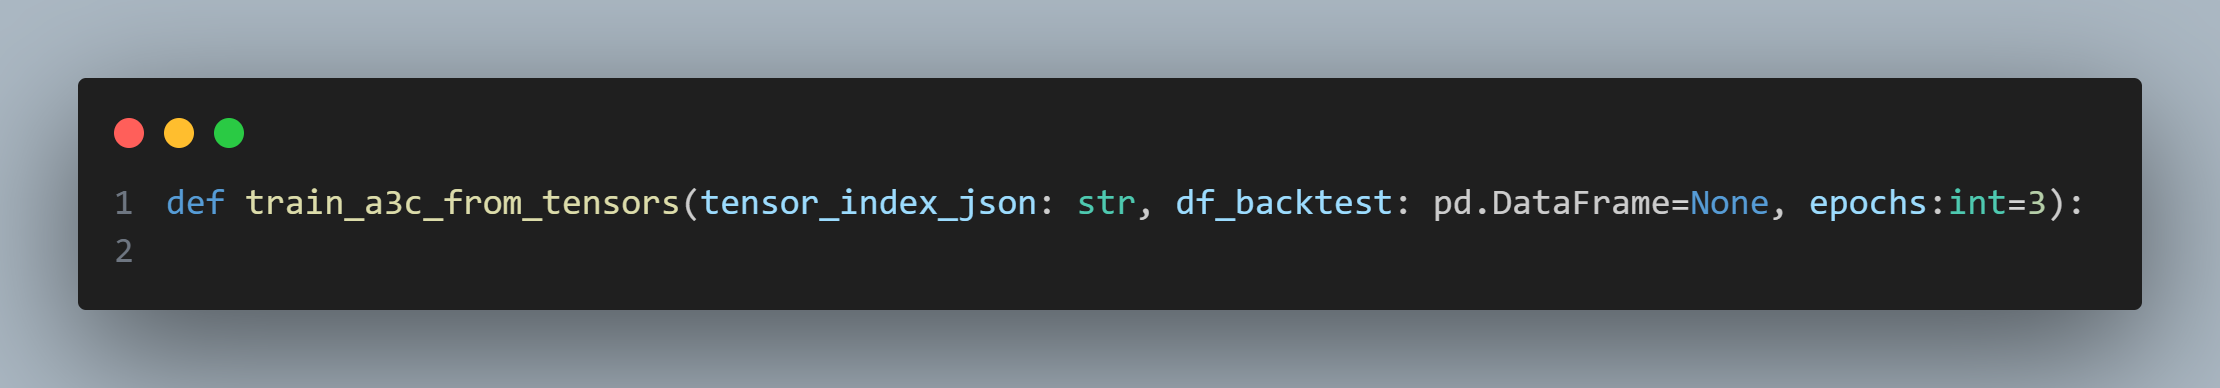

**Tuy nhiên khi triển khai thực tế ta cần epochs cao hơn để tăng độ chính xác và kết quả có thể hội tụ nên khi triển khai chạy stress test nhóm đã chỉnh lại epochs=10 nhưng bù lại thời gian chạy sẽ lâu hơn ( cell dưới nhóm chạy hết 6 phút)**


In [10]:
train_a3c_from_tensors(os.path.join(TENSOR_DIR,"tensor_index.json"), epochs=10)

[train] start A3C training from tensors (placeholder).
[train][A3C] cluster 0 epoch 1 loss 3.3411
[train][A3C] cluster 0 epoch 2 loss 0.0865
[train][A3C] cluster 0 epoch 3 loss 0.0612
[train][A3C] cluster 0 epoch 4 loss 0.0459
[train][A3C] cluster 0 epoch 5 loss 0.0344
[train][A3C] cluster 0 epoch 6 loss 0.0270
[train][A3C] cluster 0 epoch 7 loss 0.0220
[train][A3C] cluster 0 epoch 8 loss 0.0177
[train][A3C] cluster 0 epoch 9 loss 0.0152
[train][A3C] cluster 0 epoch 10 loss 0.0123
[train][A3C] saved ./models\a3c_cluster_0.pt / ./models\a3c_actor_cluster_0.pth
[train][A3C] cluster 1 epoch 1 loss 3.2417
[train][A3C] cluster 1 epoch 2 loss 0.0335
[train][A3C] cluster 1 epoch 3 loss 0.0241
[train][A3C] cluster 1 epoch 4 loss 0.0191
[train][A3C] cluster 1 epoch 5 loss 0.0162
[train][A3C] cluster 1 epoch 6 loss 0.0137
[train][A3C] cluster 1 epoch 7 loss 0.0119
[train][A3C] cluster 1 epoch 8 loss 0.0108
[train][A3C] cluster 1 epoch 9 loss 0.0094
[train][A3C] cluster 1 epoch 10 loss 0.0077
[tr

**Sau khi train lại a3c với `epochs=10` ta sẽ tiến hành chạy stress test và realtime**



`1` **Test stress test**

Khi chạy :

- Code sẽ train lại A3C + DDPG với epochs mặc định ( Nếu muốn thay đổi epochs khác mặc định thì chèn đoạn code ở cell trên `train_a3c_from_tensors(os.path.join(TENSOR_DIR,"tensor_index.json"), epochs=tự chọn)` )

- Tin nhắn log telegram sẽ hiển thị ngày backtest ( link nhóm telegram để theo dõi trả tín hiệu : `t.me/DST2025_SignalBot` )

- Cú pháp : 

**run_stress_with_daily_decisions(start_date, end_date, send_telegram = True/False)**

In [ ]:
# Test stress test từ 25/03/2025 đến 16/04/2025
run_stress_with_daily_decisions("2025-03-25", "2025-04-16", send_telegram=True)

[stress] Start: 2025-03-25 -> 2025-04-16
[init] Fiin client logged in
[replay] running for 2025-03-25
[features_master] saved snapshot -> ./features\features_today_2025-03-25.csv
[runtime] state saved
[replay] running for 2025-03-26
[features_master] saved snapshot -> ./features\features_today_2025-03-26.csv
[runtime] state saved
[replay] running for 2025-03-27
[features_master] saved snapshot -> ./features\features_today_2025-03-27.csv
[runtime] state saved
[replay] running for 2025-03-28
[features_master] saved snapshot -> ./features\features_today_2025-03-28.csv
[runtime] state saved
[replay] running for 2025-03-29
[features_master] saved snapshot -> ./features\features_today_2025-03-29.csv
[a3c] produced signals -> ./signals\a3c_signals_infer_20250922_162512.csv
[runtime] state saved
[replay] running for 2025-03-30
[features_master] saved snapshot -> ./features\features_today_2025-03-30.csv
[a3c] produced signals -> ./signals\a3c_signals_infer_20250922_163103.csv
[runtime] state sa

'./monitor\\replay_summary_20250325_20250416.csv'

`2` **Để chạy realtime ta có cú pháp sau:**

**run_cycle()**: đã bao gồm **tự động gửi tín hiệu telegram**

**run_cycle(send_telegram=False)** : Nếu không muốn gửi tín hiệu telegram


In [11]:
run_cycle()

[init] Fiin client logged in
[replay] running for 2025-09-22
[features_master] saved snapshot -> ./features\features_today_2025-09-22.csv
[a3c] produced signals -> ./signals\a3c_signals_infer_20250922_200037.csv
[runtime] state saved


{'snapshot': './features\\features_today_2025-09-22.csv',
 'a3c': './signals\\a3c_signals_2025-09-22.csv',
 'rule': './signals\\rule_scores_2025-09-22.csv',
 'alloc': None,
 'top10': None,
 'alerts': {'message_sent': True,
  'positions':   ticker  entry_date  qty  alloc
  0    ORS  2025-03-31    1    0.2
  1    HMC  2025-04-16    1    0.2
  2    TPC  2025-04-16    1    0.2
  3    VGC  2025-04-16    1    0.2
  4    OGC  2025-04-16    1    0.2,
  'telegram_text': '🟡 *NO TRADE SIGNAL (HOLD)*\nThời gian (backtest): *2025-09-22*\nVị thế hiện tại: 5/5\n  • `ORS` — alloc 20.00% (entry 2025-03-31)\n  • `HMC` — alloc 20.00% (entry 2025-04-16)\n  • `TPC` — alloc 20.00% (entry 2025-04-16)\n  • `VGC` — alloc 20.00% (entry 2025-04-16)\n  • `OGC` — alloc 20.00% (entry 2025-04-16)'}}